In [124]:
import seaborn as sns
sns.set()
import numpy as np
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

# Определим нужные нам классы

### В этом классе задаём параметры нашей активной зоны. АЗ будет представлять из себя квадрат поделённый на элементарные ячейки (квадраты поменьше). Мы должны выбрать размеры АЗ, на сколько ячеек она будет разбиваться, значения микросечений для каждой из ячеек.


In [132]:
class Core:
    "Задаются параметры активной зоны"
    
    def __init__(self, Hi, Hj, I, J, Sa, Ss, Sf):
        """Высота, ширина, кол-во разбиений по высоте и ширине соответственно,
        сечения поглощения, рассеяния и деления соответственно"""
        self.Hi = Hi
        self.Hj = Hj
        self.I = I
        self.J = J
        self.Sa = Sa
        self.Ss = Ss
        self.Sf = Sf
        self.hi = Hi/I
        self.hj = Hj/J
        self.borders()
        self.macro()

    def borders(self):
        """Рассчитываем координаты границ"""
        up_borders = np.array([[self.I * self.hi-i * self.hi for j in range(self.J)] for i in range(self.I)])
        down_borders = up_borders - self.hj
        left_borders = np.array([[j * self.hi for j in range(self.J)] for i in range(self.I)])
        right_borders = left_borders + self.hi
        self.borders = [up_borders, down_borders, left_borders, right_borders]
        pass
    
    def macro(self):
        """Задаем матрицы сечений"""
        self.SigmaAbsorption = np.ones((I, J)) * self.Sa
        self.SigmaScattering = np.ones((I, J)) * self.Ss
        self.SigmaFission = np.ones((I, J)) * self.Sf
        self.SigmaTotal = self.SigmaAbsorption + self.SigmaScattering + self.SigmaFission
        self.Sigma = [self.SigmaAbsorption, self.SigmaScattering, self.SigmaFission, self.SigmaTotal]
        pass
        
    def get_borders(self, I=None, J=None):
        """Возвращает список координат границ (верхней, нижней, левой, правой) для выбранной ячейки"""
        if I is not None and J is not None:
            try:
                return [self.borders[i][I][J] for i in range(4)]
            except IndexError:
                print(' I принимает значения от 0 до', self.I-1, '\n', 'J принимает значения от 0 до', self.J-1)
        elif I is None and J is None:
            return self.borders
        else:
            print('''Введите I и J, чтобы получить значения границ для определенной ячейки,
либо, если хотите получить сечения во всей зоне, не вводите I и J''')
            
    def get_centr(self, I, J):
        """Возвращает координаты центра для какой-либо ячейки"""
        return [self.get_borders(I, J)[2]+(self.get_borders(I, J)[3] - self.get_borders(I, J)[2])/2,
                self.get_borders(I, J)[1]+(self.get_borders(I, J)[0] - self.get_borders(I, J)[1])/2]

    def get_section(self, type_of_section, I=None, J=None):
        "Возвращает значения сечения для выбранной ячейки"
        if I is not None and J is not None:
            try:
                return self.Sigma[type_of_section][I][J]
            except IndexError:
                print(' I принимает значения от 0 до', self.I-1, '\n', 'J принимает значения от 0 до', self.J-1, '\n',
                      '''4 типа микросечений:
                      0 - Absorption
                      1 - Scattering
                      2 - Fission
                      3 - Total''')
        elif I is None and J is None:
            return self.Sigma[type_of_section]
        else:
            print('''Введите I и J, чтобы получить микросечение для определенной ячейки,
либо, если хотите получить сечения во всей зоне, не вводите I и J''')
            
    def get_heathmap(self, type_of_section):
        """Возвращает heatmap для выбранного сечения"""
        return sns.heatmap(self.Sigma[type_of_section], annot=True, linewidths=.5)
        
    def get_map_of_cell(self):
        """Возвращает матрицу, где показана нумерация ячеек"""
        map_ = ([[('i' + str(i) + ' ' + 'j' + str(j)) for j in range(self.J)] for i in range(self.I)])
        return map_
        
    def put_section(self, sigma, type_of_section, i, j):
        """Изменить сечение в какой-люибо ячейке"""
        self.Sigma[type_of_section][i][j] = sigma
        pass
        
        

### Класс определяет геометрию элементарной ячейки.

In [126]:
class Geometry:
    """Определяет границу, в направлении которой полетит нейтрон;
       расстояние, которое он пройдет в ячейке;
       вылетит он из ячейки или нет"""
    
    def __init__(self, up_border, down_border, left_border, right_border, x, y, cos_fi, sin_fi):
        self.up_border = up_border
        self.down_border = down_border
        self.left_border = left_border
        self.right_border = right_border
        self.x = x
        self.y = y
        self.cos_fi = cos_fi
        self.sin_fi = sin_fi
        self.tg_fi = sin_fi / cos_fi
    
    def direction(self):
        """Возвращает номер границы, в направлении которой полетит нейтрон
        1 - правая
        2 - верхняя
        3 - левая
        4 - нижняя"""
        
        # работает
        def distance(border, coordinate):
            "Длина нормали до границы"
            return abs(coordinate - border)
        
        distance_list = []
        distance_list = list(map(distance, [self.up_border, self.down_border, self.left_border, self.right_border],
                             [self.y, self.y, self.x, self.x]))        
        self.distance_list = distance_list
        
        def tg_alfa(first_cathet, second_cathet):
            "tg направления вектора из координаты нейтрона к одному из углов"
            try:
                return first_cathet / second_cathet
            except ZeroDivisionError:
                    # Если один из катетов равен 0, значит нейтрон попал точно на границу,
                    # Предположим, что граница является частью элементарной ячейки.
                    return first_cathet * 100
                
        tg_alfa_list = []
        tg_alfa_list = list(map(tg_alfa, [distance_list[0],
                                          distance_list[0],
                                          -distance_list[1],
                                          -distance_list[1]],
                                [distance_list[3], 
                                 -distance_list[2],
                                 -distance_list[2],
                                 distance_list[3]]))
        
        if self.sin_fi >= 0:
            if self.tg_fi >= 0 and self.tg_fi <= tg_alfa_list[0]:
                self.dl = distance_list[3] / abs(self.cos_fi)
                self.border = 1
                
                return 1
            elif self.tg_fi < 0 and self.tg_fi >= tg_alfa_list[1]:
                self.dl = distance_list[2] / abs(self.cos_fi)
                self.border = 3
                
                return 3
            else:
                self.dl = distance_list[0] / abs(self.sin_fi)
                self.border = 2
                
                return 2
        else:
            if self.tg_fi < 0 and self.tg_fi >= tg_alfa_list[3]:
                self.dl = distance_list[3] / abs(self.cos_fi)
                self.border = 1
                
                return 1
            elif self.tg_fi >= 0 and self.tg_fi < tg_alfa_list[2]:
                self.dl = distance_list[2] / abs(self.cos_fi)
                self.border = 3
                
                return 3
            else:
                self.border = 4
                self.dl = distance_list[1] / abs(self.sin_fi)
                return 4

    def way(self):
        "Возвращает длину пути, которую нужно преодолеть нейтрону, чтобы пересечь границу"
        try:
            return self.dl
        except AttributeError:
            print("""Для того, чтобы узнать длину пути, которую нужно преодолеть нейтрону,
                  чтобы пересечь границу, нужно знать эту границу (выполните метод direction)""")
        
    def departure(self, S, St, i, j):
        "Возвращает 1, если нейтрон вылетел из элеменатрной ячейки и 0, если не велетел. S / st - длина пробега нейтрона"
        self.i = i
        self.j = j
        self.S = S
        if S/St > self.dl:
            # вылетел
            if self.border == 1:
                self.i_new = self.i
                self.j_new = self.j + 1
            elif self.border == 2:
                self.j_new = self.j
                self.i_new = self.i - 1
            elif self.border == 3:
                self.i_new = self.i
                self.j_new = self.j - 1
            elif self.border == 4:
                self.j_new = self.j
                self.i_new = self.i + 1
            self.S_new = self.S - self.dl * St
            self.x_new = self.x + self.dl * self.cos_fi
            self.y_new = self.y + self.dl * self.sin_fi
            return 1
        else:
            # не вылетел
            self.x_new = self.x + abs(self.S / St) * self.cos_fi
            self.y_new = self.y + abs(self.S / St) * self.sin_fi
            self.i_new = self.i
            self.j_new = self.j
            self.S_nex = self.S
            return 0
    
    def new_x(self):
        "Возвращает новую координату по оси х"
        try:
            return self.x_new
        except AttributeError:
            print("""Чтобы определить новую координату, нужно знать вылетел ли нейтрон из ячейки
            (выполните departure)""")
            
    def new_y(self):
        "Возвращает овую координату по оси у"
        try:
            return self.y_new
        except AttributeError:
            print("""Чтобы определить новую координату, нужно знать вылетел ли нейтрон из ячейки
            (выполните departure)""")
    
    def new_i(self):
        
        "Возвращает новый номер ячейки"
        try:
            return self.i_new
        except AttributeError:
            print("""Чтобы определить новую ячейку, нужно знать вылетел ли нейтрон из ячейки
             (выполните departure)""")
            
    def new_j(self):
        "Возвращает новый номер ячейки"
        try:
            return self.j_new
        except AttributeError:
            print("""Чтобы определить новую ячейку, нужно знать вылетел ли нейтрон из ячейки
            (выполните departure)""")
    
    def new_S(self):
        """S - путь, который бы преодолел нейтрон, если бы сечение захвата равнялось 1. Зависит от энергии. В данной модели 
        выбирается логарифмом равномерно распределенной случайной величины"""
        try:
            return self.S_new
        except AttributeError:
            print("""Чтобы переопределить S, нужно знать вылетел ли нейтрон из ячейки
            (выполните departure)""")

### Класс, который хранит информацию о дейстиях нейтрона. В какой ячейке он поглотился, разделил ядро или вылетел из АЗ.

In [127]:
class Out:
    
    def __init__(self, I, J):
        self.I = I
        self.J = J
        self.__rezult__()
        
    def __int_str__(self, i, j):
        return str(i) + str(j)
        
    def __rezult__(self):
        
        self.Number_of_absorbed = {}
        self.Number_of_scattered = {}
        self.Number_of_fission = {}
        self.Number_of_Outer = 0
        
        for i in range(self.I):
            for j in range(self.J):
                ij = self.__int_str__(i, j)
                self.Number_of_absorbed[ij] = 0
                self.Number_of_scattered[ij] = 0
                self.Number_of_fission[ij] = 0
        pass

    def put_absorbed_neutron(self, i, j):
        """Записываем где поглотился нейтрон"""
        ij = self.__int_str__(i, j)
        self.Number_of_absorbed[ij] += 1
        pass

    def put_fission_neutron(self, i, j):
        """Записываем где разделился нейтрон"""
        ij = self.__int_str__(i, j)
        self.Number_of_fission[ij] += 1
        pass        
        
    def put_out_neutron(self):
        """Считаем вылетевшие из АЗ нейтроны"""
        self.Number_of_Outer += 1
        pass
    
    def get_out_neutron(self):
        """Возвращает кол-во вылетевших из АЗ нейтронов"""
        return self.Number_of_Outer
    
    def get_absorbed(self):
        """Возвращает матрицу поглотившихся нейтронов"""
        return np.array([[self.Number_of_absorbed[str(i)+str(j)] for j in range(self.J)] for i in range(self.I)])
    
    def get_fission(self):
        """Возвращает матрицу нейтронов разделивших ядро"""
        return np.array([[self.Number_of_fission[str(i)+str(j)] for j in range(self.J)] for i in range(self.I)])
        
        

# Начало

In [128]:
# задаем область
# кол-во эл-х ячеек
I = 7
J = 7
# размер всей области
Hi = 25
Hj = 25
# размер ячейки (все ячейки равны)
hi = Hi / I
hj = Hj / J
# Задаем сечения
Sa = 0.07
Ss = 0.09
Sf = 0.0044
# начальный поток(кол-во нейтронов в элементарной ячейке)
q0 = 40000
# Задаем кол-во итераций
iteration = 5
# кол-во новых нейтронов на деление
nueff = 2.73


In [129]:
# задаём Активную Зону
AZ = Core(Hi, Hj, I, J, Sa, Ss, Sf)


In [130]:
# Посмотрим на индексацию элементарных ячеек
AZ.get_map_of_cell()


[['i0 j0', 'i0 j1', 'i0 j2', 'i0 j3', 'i0 j4', 'i0 j5', 'i0 j6'],
 ['i1 j0', 'i1 j1', 'i1 j2', 'i1 j3', 'i1 j4', 'i1 j5', 'i1 j6'],
 ['i2 j0', 'i2 j1', 'i2 j2', 'i2 j3', 'i2 j4', 'i2 j5', 'i2 j6'],
 ['i3 j0', 'i3 j1', 'i3 j2', 'i3 j3', 'i3 j4', 'i3 j5', 'i3 j6'],
 ['i4 j0', 'i4 j1', 'i4 j2', 'i4 j3', 'i4 j4', 'i4 j5', 'i4 j6'],
 ['i5 j0', 'i5 j1', 'i5 j2', 'i5 j3', 'i5 j4', 'i5 j5', 'i5 j6'],
 ['i6 j0', 'i6 j1', 'i6 j2', 'i6 j3', 'i6 j4', 'i6 j5', 'i6 j6']]

<IPython.core.display.Javascript object>


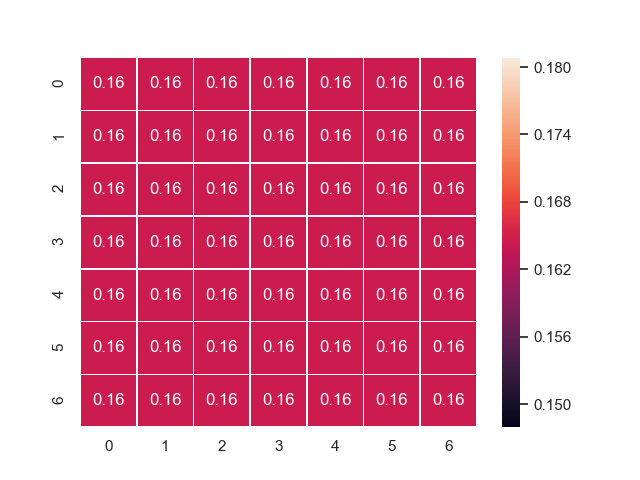

In [131]:
# Посмотрим на сумму всех сечений
AZ.get_heathmap(3)


In [7]:
# Начинаем цикл по итерациям
calculation = []
fi_calculation = []
for it in range(iteration):

    if it == 0:
        Q = q0 * np.ones((I, J), dtype=int)
    else:
        Q = np.array(nueff * Iteration_rezult.get_fission(), dtype=int)
    # В начале каждой итерации инициализипуем класс Out
    Iteration_rezult = Out(I, J)
    for i in range(I):
        random.seed()
        for j in range(J):
            for n in range(Q[i][j]):
                up_border = AZ.get_borders(i, j)[0]
                down_border = AZ.get_borders(i, j)[1]
                left_border = AZ.get_borders(i, j)[2]
                right_border = AZ.get_borders(i, j)[3]
                x = AZ.get_centr(i, j)[0]
                y = AZ.get_centr(i, j)[1]
                ii = i
                jj = j
                while True:
                
                    alfa = random.random()
                    cos_fi = np.cos(alfa * 2 * np.pi)
                    sin_fi = np.sin(alfa * 2 * np.pi)
                    S = -np.log(random.random())
                    out = 0
                    kkk = 0
                    # цикл по рассеянию
                    while True:
                        if kkk > 1000:
                            print('нейтрон рассеялся 1000 раз и \
                                  не вылетел или поглотился!')
                            break
                        cell = Geometry(up_border, down_border,
                                        left_border, right_border,
                                        x, y, cos_fi, sin_fi)
                        Border_number = cell.direction()
                        Distance_to_border = cell.way()
                        Departure = cell.departure(S, AZ.get_section(3, ii, jj),
                                                   ii, jj)
                        ii = cell.new_i()
                        jj = cell.new_j()
                        if Departure == 0:
                            # значит нейтрон проивзаимодействовал внутри ячейки.
                            break
                        if ii < 0 or jj < 0 or jj > J-1 or ii > I-1:
                            # вылетел за пределы АЗ
                            out = 1
                            break
                        up_border = AZ.get_borders(ii, jj)[0]
                        down_border = AZ.get_borders(ii, jj)[1]
                        left_border = AZ.get_borders(ii, jj)[2]
                        right_border = AZ.get_borders(ii, jj)[3]
                        x = cell.new_x()
                        y = cell.new_y()
                        S = cell.new_S()
                        kkk += 1
                    # Выходим из цикла, если нейтрон вылетел за пределы АЗ
                    if out == 1:
                        Iteration_rezult.put_out_neutron()
                        break
                    r = random.random()
                    # Определяем тип взаимодействия
                    if r < AZ.get_section(0, ii, jj)/AZ.get_section(3, ii, jj):
                        Iteration_rezult.put_absorbed_neutron(ii, jj)
                        break
                    # если рассеялся продолжаем цикл с новым углом и S
                    elif (AZ.get_section(0, ii, jj) / AZ.get_section(3, ii, jj) >= r) \
                        and (r < (AZ.get_section(0, ii, jj) + AZ.get_section(1, ii, jj)) / AZ.get_section(3, ii, jj)):
                        continue
                    else:
                        Iteration_rezult.put_fission_neutron(ii, jj)
                        break
    # Рассчитаем среднее по потоку
    avg_fi = int((sum(sum(Iteration_rezult.get_fission()
                          + Iteration_rezult.get_absorbed())))/(I * J))
    # Нормируем поток на среднее
    fi = (Iteration_rezult.get_absorbed()
          + Iteration_rezult.get_fission())/avg_fi
    print('итерация №', it)
    print(np.round(fi, decimals=3))
    calculation.append(Iteration_rezult.get_fission())
    fi_calculation.append(fi)
    # Вычислим коэфициент размножения среды
    if it > 0:
        print('Keff = ', 
              sum(sum(calculation[len(calculation)-1]))/sum(sum(calculation[len(calculation)-2])))


c:\apps\python37\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in double_scalars


итерация № 0
[[0.725 0.87  0.923 0.916 0.906 0.861 0.722]
 [0.87  1.033 1.104 1.132 1.107 1.047 0.869]
 [0.905 1.112 1.172 1.182 1.174 1.111 0.914]
 [0.922 1.12  1.188 1.206 1.192 1.125 0.919]
 [0.918 1.103 1.176 1.197 1.174 1.102 0.919]
 [0.87  1.045 1.102 1.119 1.121 1.041 0.865]
 [0.723 0.864 0.915 0.923 0.907 0.864 0.725]]
итерация № 1
[[0.592 0.79  0.869 0.878 0.868 0.779 0.595]
 [0.78  1.035 1.156 1.186 1.156 1.035 0.785]
 [0.87  1.151 1.283 1.325 1.282 1.156 0.86 ]
 [0.881 1.196 1.317 1.358 1.318 1.191 0.888]
 [0.873 1.149 1.268 1.334 1.27  1.153 0.866]
 [0.782 1.042 1.149 1.179 1.158 1.033 0.786]
 [0.596 0.78  0.868 0.887 0.859 0.788 0.599]]
Keff =  1.1838431193870578
итерация № 2
[[0.527 0.729 0.839 0.872 0.843 0.728 0.529]
 [0.733 1.031 1.17  1.218 1.188 1.03  0.745]
 [0.838 1.17  1.344 1.405 1.356 1.174 0.84 ]
 [0.872 1.222 1.407 1.46  1.407 1.222 0.868]
 [0.841 1.172 1.335 1.398 1.342 1.174 0.838]
 [0.728 1.021 1.169 1.219 1.162 1.026 0.735]
 [0.537 0.735 0.836 0.869 0.834 

 Можно заметить, что распределение потока соответствует теории. Т.к. сечения во всех ячейках одинаковы, максимальный поток наблюдпется в центре. По краям зоны он минимален, т.к. происходит утечка нейтронов.
   Т.к. Keff > 0 значение потока увеличивается на каждой итерации.

## Создадим график потока в зависимости от ячейки 

<IPython.core.display.Javascript object>


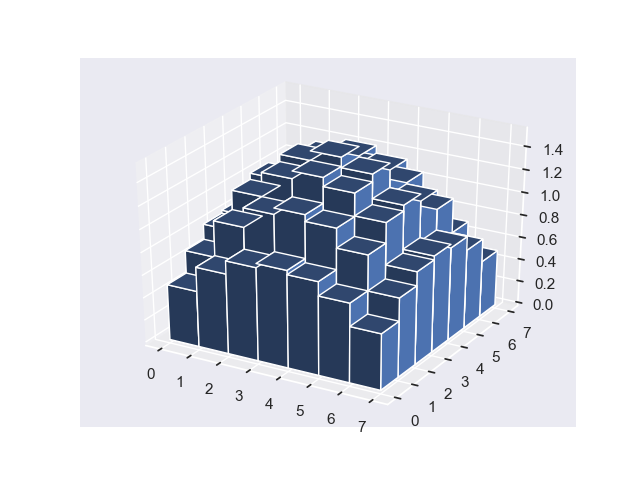

In [116]:
matrix = fi_calculation[3]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Начальные позиции
xpos = [range(I)]
ypos = [range(J)]
xpos, ypos = np.meshgrid(xpos, ypos)
xpos = xpos.flatten('F')
ypos = ypos.flatten('F')
zpos = np.zeros_like(xpos)

# Длина, ширина и высота столбцов
dx = np.ones_like(zpos)
dy = dx.copy()
dz = matrix.flatten()
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='b', zsort='average')
plt.show()


